# 1. ResNet网络

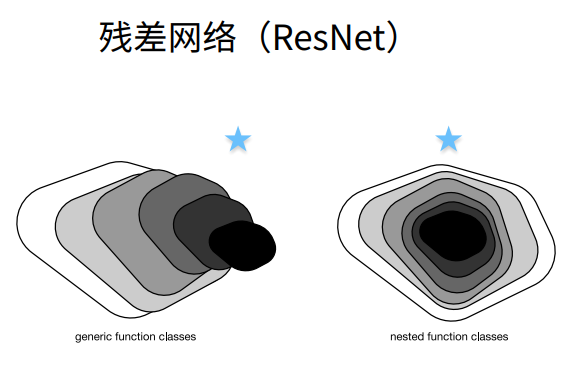

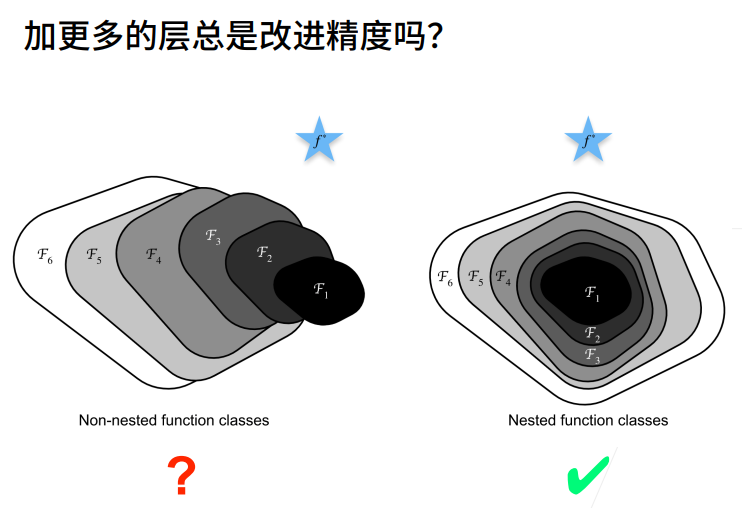

① 这样直接加保证了最优解“至少不会变差”，g(x)=0是和以前一样的。假设没有学到任何东西，则g(x)为0。

② 这个x实际上是f0(x)，就是上幅图小的部分，f(x)是f1(x)，新函数包含原函数。

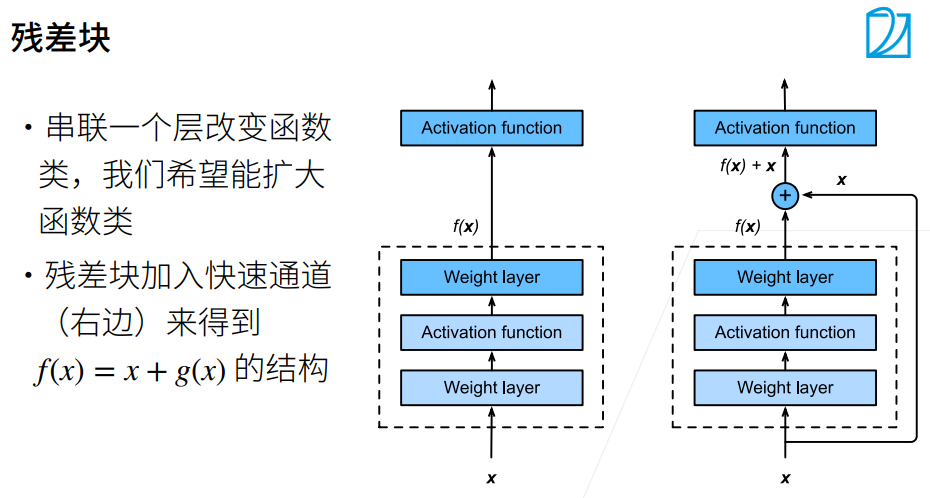

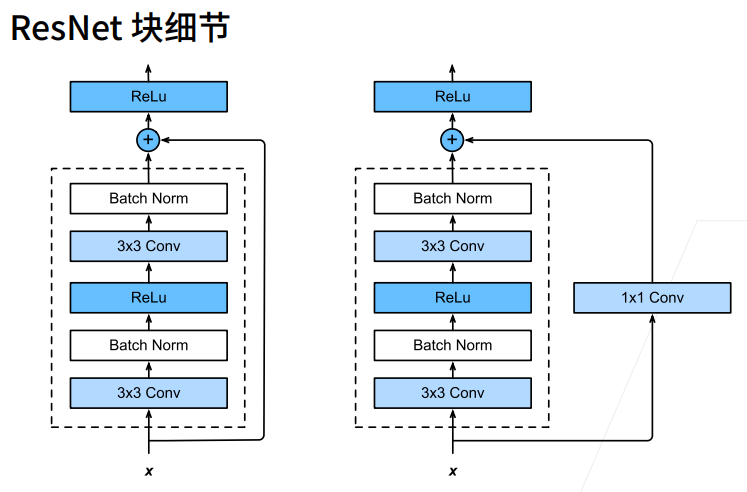

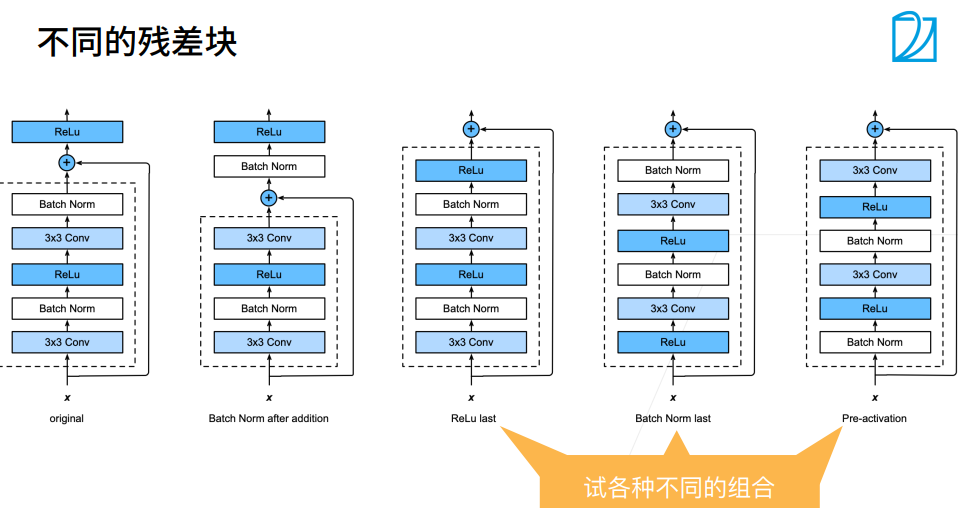

① g(x)高宽减半的同时，1x1 conv的strides=2，也把x高宽减半了。

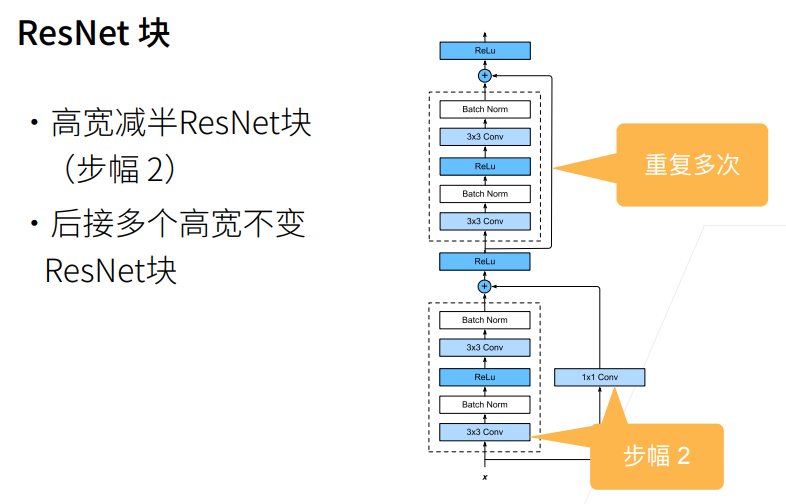

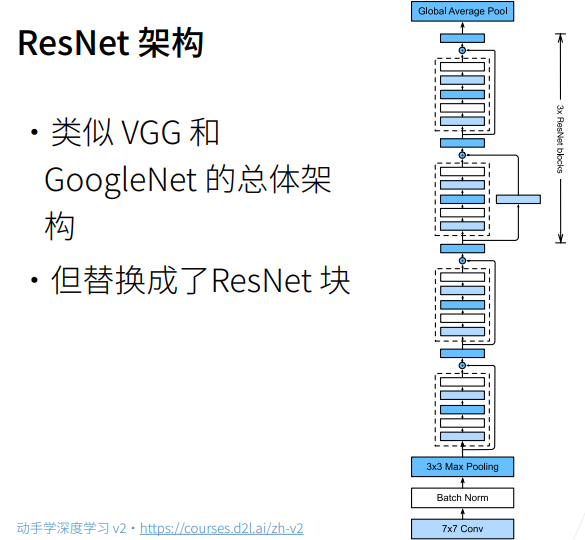

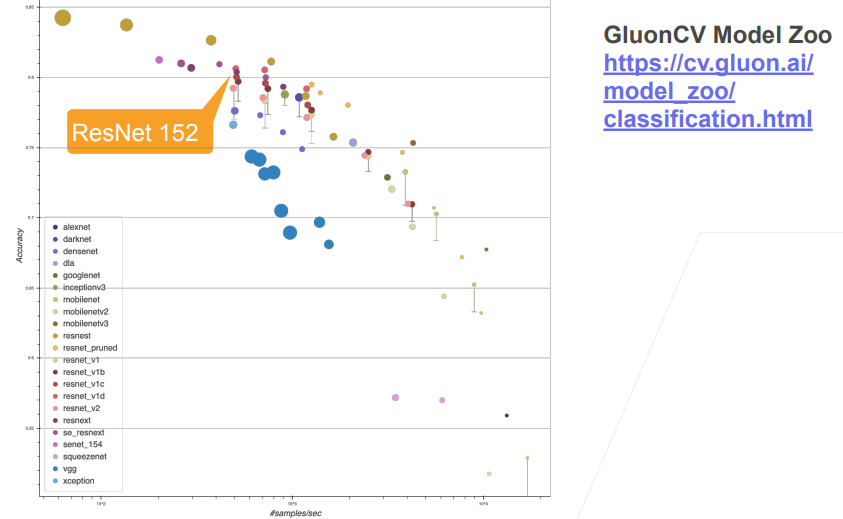

# 2. 总结

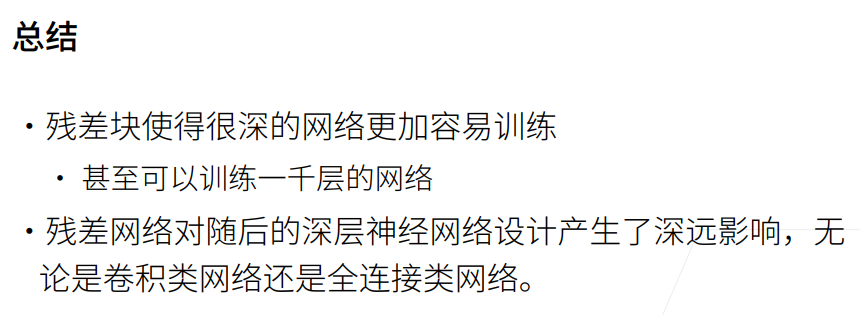

# 1. ResNet网络（使用自定义）

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual (nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False,strides=1): # num_channels为输出channel数  
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides) # 可以使用传入进来的strides 
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)   # 使用nn.Conv2d默认的strides=1
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)   
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True) # inplace原地操作，不创建新变量，对原变量操作，节约内存
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [2]:
# 输入和输出形状一致
blk = Residual(3,3) # 输入三通道，输出三通道
X = torch.rand(4,3,6,6) 
Y = blk(X) # stride用的默认的1，所以宽高没有变化。如果strides用2，则宽高减半
Y.shape

torch.Size([4, 3, 6, 6])

In [3]:
# 增加输出通道数的同时，减半输出的高和宽
blk = Residual(3,6,use_1x1conv=True,strides=2)  # 由3变为6，通道数加倍
blk(X).shape

torch.Size([4, 6, 3, 3])

In [4]:
# ResNet的第一个stage
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                  nn.BatchNorm2d(64),nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

# class Residual为小block，resnet_block 为大block，为Resnet网络的一个stage
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block: # stage中不是第一个block则高宽减半
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True,strides=2))   
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True)) # 因为b1做了两次宽高减半，nn.Conv2d、nn.MaxPool2d，所以b2中的首次就不减半了      
b3 = nn.Sequential(*resnet_block(64,128,2)) # b3、b4、b5的首次卷积层都减半
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

net = nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveAvgPool2d((1,1)),nn.Flatten(),nn.Linear(512,10))    

In [5]:
# 观察一下ReNet中不同模块的输入形状是如何变化的
X = torch.rand(size=(1,1,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape) # 通道数翻倍、模型减半

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.009, train acc 0.998, test acc 0.921
2166.7 examples/sec on cuda:0


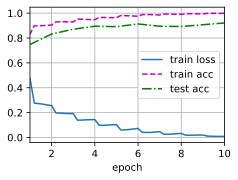

In [6]:
# 训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)  
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())